<a href="https://colab.research.google.com/github/vishvesh-coreteams/vishvesh/blob/main/XG_boost_predice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload your file


Saving update_anahadSalesfullData.csv to update_anahadSalesfullData.csv


In [4]:
df = pd.read_csv("update_anahadSalesfullData.csv")  # Change the file name accordingly


In [7]:
df["date"] = pd.to_datetime(df["InvDate"], format='%d-%m-%Y %H:%M', errors='coerce')
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month


In [9]:
df["lag_1"] = df.groupby("PId")["Qty"].shift(1)
df["lag_2"] = df.groupby("PId")["Qty"].shift(2)
df["lag_3"] = df.groupby("PId")["Qty"].shift(3)


In [10]:
df["rolling_mean_3"] = df.groupby("PId")["Qty"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df["rolling_mean_6"] = df.groupby("PId")["Qty"].transform(lambda x: x.rolling(window=6, min_periods=1).mean())


In [11]:
df["is_winter"] = df["month"].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df["is_summer"] = df["month"].apply(lambda x: 1 if x in [6, 7, 8] else 0)


In [12]:
df.fillna(0, inplace=True)


<ipython-input-12-a616889d5bf1>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


In [13]:
features = ["year", "month", "lag_1", "lag_2", "lag_3", "rolling_mean_3", "rolling_mean_6", "is_winter", "is_summer"]
X = df[features]
y = df["Qty"]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)


In [15]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = xgb_model.predict(X_test)


In [17]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score = xgb_model.score(X_test, y_test)

print(f"Model Performance:\nMAE: {mae}\nRMSE: {rmse}\nR² Score: {r2_score}")


Model Performance:
MAE: 0.297499528528367
RMSE: 7.325517126157516
R² Score: 0.4250118161336486


In [18]:
pred_std = np.std(y_pred - y_test)
lower_bound = y_pred - 1.96 * pred_std
upper_bound = y_pred + 1.96 * pred_std


In [19]:
def predict_demand_range(product_id, month, year):
    product_data = df[df["PId"] == product_id].sort_values("date").iloc[-1]
    input_data = pd.DataFrame({
        "year": [year], "month": [month], "lag_1": [product_data["Qty"]],
        "lag_2": [product_data["lag_1"]], "lag_3": [product_data["lag_2"]],
        "rolling_mean_3": [product_data["rolling_mean_3"]], "rolling_mean_6": [product_data["rolling_mean_6"]],
        "is_winter": [1 if month in [12, 1, 2] else 0], "is_summer": [1 if month in [6, 7, 8] else 0]
    })
    predicted_Qty = xgb_model.predict(input_data)[0]
    lower = max(0, round(predicted_Qty - 1.96 * pred_std))
    upper = round(predicted_Qty + 1.96 * pred_std)
    return lower, upper


In [20]:
product_id = 16408
month = 3
year = 2024

predicted_range = predict_demand_range(product_id, month, year)
print(f"Predicted demand range for product {product_id} in {month}/{year}: {predicted_range}")


Predicted demand range for product 16408 in 3/2024: (0, 16)


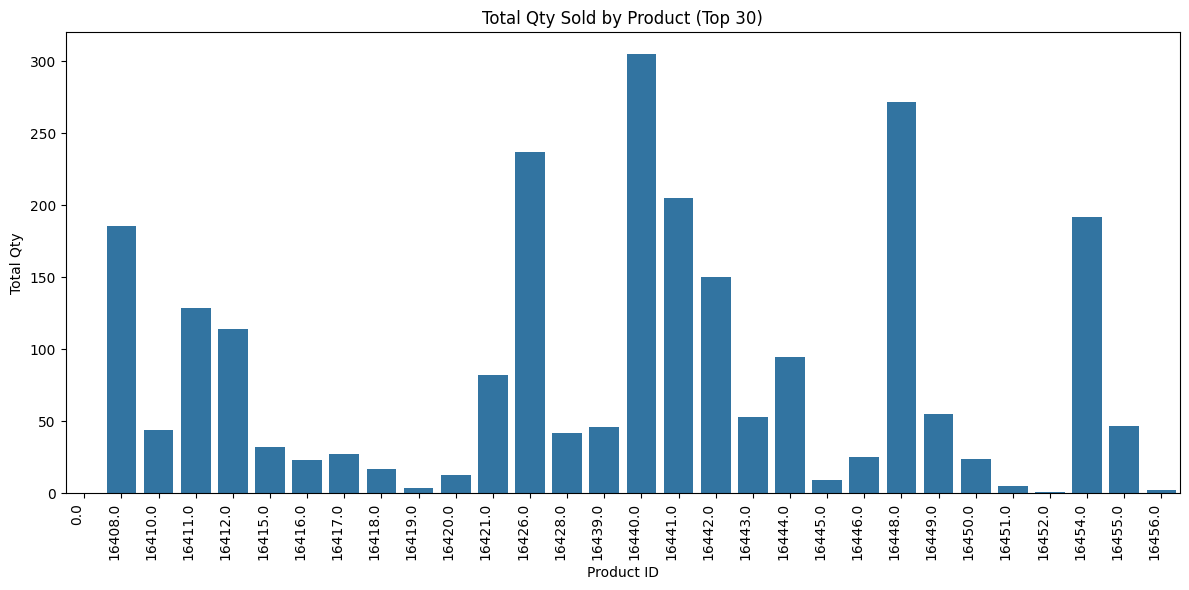

In [21]:
product_quantities = df.groupby("PId")["Qty"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="PId", y="Qty", data=product_quantities.head(30))  # Top 30 for better visualization
plt.title("Total Qty Sold by Product (Top 30)")
plt.xlabel("Product ID")
plt.ylabel("Total Qty")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()
